![Cold water cascades over the rocks in Erwin, Tennessee.](main.jpg "")

Friends, this is going to be an epic post! Today, we bring together all the ideas we've built up over the past few posts to nail down our understanding of the key ideas in Jerome Friedman's seminal 2001 paper: "[Greedy Function Approximation: A Gradient Boosting Machine](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf)."
In particular, we'll summarize the highlights from the paper, and we'll build an in-house python implementation of his generic gradient boosting algorithm which can train with any differentiable loss function.
What's more, we'll go ahead and take our generic gradient boosting machine for a spin by training it with several of the most popular loss functions used in practice.

Are you freaking stoked or what?

Sweet. Let's do this.


## Friedman 2001: TL;DR

I've mentioned this paper a couple of times before, but as far as I can tell, this is the origin of gradient boosting; it is therefore, a seminal work worth reading.
You know what, I think you might like to pick up [the paper](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) and read it yourself. Like many papers, there is a lot of scary looking math in the first few pages, but if you've been following along on  this blog, you'll find that it's actually totally approachable. 
This is the kind of thing that cures imposter syndrome, so give it a shot.
That said, here's the TL;DR as I see it.


The first part of the paper introduces the idea of fitting models by doing gradient descent in function space, an ingenious idea we spent  [an entire post](/posts/how-gradient-boosting-does-gradient-descent/) demystifying earlier.
Friedman goes on to introduce the generic gradient boost algorithm, which works with any differentiable loss function, as well as specific variants for minimizing absolute error, Huber loss, and binary deviance.
In terms of hyperparameters, he points out that the learning rate can be used to reduce overfitting, while increased tree depth can help capture more complex interactions among features.
He even discusses feature importance and partial dependence methods for interpreting fitted gradient boosting models.

Friedman concludes by musing about the advantages of gradient boosting with trees.
He notes some key advantages afforded by the use of decision trees including no need to rescale input data, robustness against irrelevant input features, and elegant handling of missing feature values.
He points out that gradient boosting manages to capitalize on the benefits of decision trees while minimizing their key weakness (crappy accuracy). 
I think this offers a great insight into why gradient boosting models have become so widespread and successful in practical ML applications.


## Friedman's Generic Gradient Boosting Algorithm 
Let's take a closer look at  Friedman's original gradient boost algorithm, Alg. 1 in Section 3 of [the paper](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) (translated into the notation we've been using so far). 

Like last time, we have training data $(\mathbf{y}, \mathbf{X})$ where $\mathbf{y}$ is a length-$n$ vector of target values, and $\mathbf{X}$ is an $n \times p$ matrix with $n$ observations of $p$ features. We also have a differentiable loss function $L(\mathbf{y}, \mathbf{\hat{y}}) = \sum_{i=1}^n l(y_i, \hat{y}_i)$, a "learning rate" hyperparameter $\eta$, and a fixed number of model iterations $M$.

**Algorithm:** *gradient_boost*$(\mathbf{X},\mathbf{y},L,\eta, M)$ returns: model $F_M$

1. Let base model
$F_0(\mathbf{x}) = c$, where $c = \text{argmin}_{c} \sum_{i=1}^n l(y_i, c)$

1. `for` $m$ = $0$ to $M-1$:

1. 
&nbsp;&nbsp;&nbsp;&nbsp;
Let "pseudo-residual" vector 
$\mathbf{r}_m = -\nabla_{\mathbf{\hat{y}}_m} L(\mathbf{y},\mathbf{\hat{y}}_m)$

1. 
&nbsp;&nbsp;&nbsp;&nbsp;
Train decision tree regressor $h_m(\mathbf{X})$ to predict $\mathbf{r}_m$ (minimizing squared error)

1. 
&nbsp;&nbsp;&nbsp;&nbsp;
`foreach` terminal leaf node $t \in h_m$:

1. 
&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;
Let $v = \text{argmin}_v \sum_{i \in t} l(y_i, F_m(\mathbf{x}_i) + v)$

1. 
&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;
Set terminal leaf node $t$ to predict value $v$

1. 
&nbsp;&nbsp;&nbsp;&nbsp;
$F_{m+1}(\mathbf{X}) = F_{m}(\mathbf{X}) + \eta h_m(\mathbf{X})$

1. Return composite  model $F_M$


By now, most of this is already familiar to us. 
We begin by setting the base model $F_0$ equal to the constant prediction value that minimizes the loss over all examples in the training dataset (line 1).
Then we begin the boosting iterations (line 2), each time computing the negative gradients of the loss with respect to the current model predictions (known as the pseudo residuals) (line 3).
We then fit our next decision tree regressor to predict the pseudo residuals (line 4). 

Then we encounter something new on lines 5-7.
When we fit a vanilla decision tree regressor to predict pseudo residuals, we're using mean squared error as the loss function to train the tree.
As you might imagine, this works well when the global loss function is also squared error.
But if we want to use a global loss other than squared error, there is an additional trick we can use to further increase the composite model's accuracy.
The idea is to continue using squared error to train each decision tree, keeping its structure and split conditions but altering the predicted value in each leaf to help minimize the global loss function.
Instead of using the mean target value as the prediction for each node (as we would do when minimizing squared error), we use a numerical optimization method like line search to choose the constant value for that leaf that leads to the best overall loss. This is the same thing we did in line 1 of the algorithm to set the base prediction, but here we choose the optimal prediction for each terminal node of the newly trained decision tree.

## Implementation

I did some (half-assed) searching on the interweb for an implementation of GBM that allows the user to provide a custom loss function, and you know what? I couldn't find anything. If you find another implementation, post in the comments so we can learn from it too.

Since we need to modify the values predicted by our decision trees' terminal nodes, we'll want to brush up on the scikit-learn [decision tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html) before we get going. 
You can see explanations of all the necessary decision tree hacks in this [notebook](https://github.com/mcb00/blog/blob/master/supplemental/friedman-gbm-implementation.ipynb).


In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor 
from scipy.optimize import minimize

class GradientBoostingMachine():
    '''Gradient Boosting Machine supporting any user-supplied loss function.
    
    Parameters
    ----------
    n_trees : int
        number of boosting rounds
        
    learning_rate : float
        learning rate hyperparameter
        
    max_depth : int
        maximum tree depth
    '''
    
    def __init__(self, n_trees, learning_rate=0.1, max_depth=1):
        self.n_trees=n_trees; 
        self.learning_rate=learning_rate
        self.max_depth=max_depth;
    
    def fit(self, X, y, objective):
        '''Fit the GBM using the specified loss function.
        
        Parameters
        ----------
        X : ndarray of size (number observations, number features)
            design matrix
            
        y : ndarray of size (number observations,)
            target values
            
        objective : loss function class instance
            Class specifying the loss function for training.
            Should implement two methods:
                loss(labels: ndarray, predictions: ndarray) -> float
                negative_gradient(labels: ndarray, predictions: ndarray) -> ndarray
        '''
        
        self.trees = []
        self.base_prediction = self._get_optimal_base_value(y, objective.loss)
        current_predictions = self.base_prediction * np.ones(shape=y.shape)
        for _ in range(self.n_trees):
            pseudo_residuals = objective.negative_gradient(y, current_predictions)
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, pseudo_residuals)
            self._update_terminal_nodes(tree, X, y, current_predictions, objective.loss)
            current_predictions += self.learning_rate * tree.predict(X)
            self.trees.append(tree)
     
    def _get_optimal_base_value(self, y, loss):
        '''Find the optimal initial prediction for the base model.'''
        fun = lambda c: loss(y, c)
        c0 = y.mean()
        return minimize(fun=fun, x0=c0).x[0]
        
    def _update_terminal_nodes(self, tree, X, y, current_predictions, loss):
        '''Update the tree's predictions according to the loss function.'''
        # terminal node id's
        leaf_nodes = np.nonzero(tree.tree_.children_left == -1)[0]
        # compute leaf for each sample in ``X``.
        leaf_node_for_each_sample = tree.apply(X)
        for leaf in leaf_nodes:
            samples_in_this_leaf = np.where(leaf_node_for_each_sample == leaf)[0]
            y_in_leaf = y.take(samples_in_this_leaf, axis=0)
            preds_in_leaf = current_predictions.take(samples_in_this_leaf, axis=0)
            val = self._get_optimal_leaf_value(y_in_leaf, 
                                               preds_in_leaf,
                                               loss)
            tree.tree_.value[leaf, 0, 0] = val
            
    def _get_optimal_leaf_value(self, y, current_predictions, loss):
        '''Find the optimal prediction value for a given leaf.'''
        fun = lambda c: loss(y, current_predictions + c)
        c0 = y.mean()
        return minimize(fun=fun, x0=c0).x[0]
          
    def predict(self, X):
        '''Generate predictions for the given input data.'''
        return (self.base_prediction 
                + self.learning_rate 
                * np.sum([tree.predict(X) for tree in self.trees], axis=0))

In terms of design, we implement a class for the GBM with scikit-like `fit` and `predict` methods. Notice in the below implementation that the `fit` method is only 10 lines long, and corresponds very closely to Friedman's gradient boost algorithm from above.  Most of the complexity comes from the helper methods for updating the leaf values according to the specified loss function.

When the user wants to call the `fit` method, they'll need to supply the loss function they want to use for boosting. We'll make the user implement their loss (a.k.a. objective) function as a class with two methods: (1) a `loss` method taking the labels and the predictions and returning the loss score and (2) a `negative_gradient` method taking the labels and the predictions and returning an array of negative gradients.


## Testing our Model

Let's test drive our custom-loss-ready GBM with a few different loss functions!
We'll compare it to the scikit-learn GBM to sanity check our implementation.

In [2]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

rng = np.random.default_rng()

# test data
def make_test_data(n, noise_scale):
    x = np.linspace(0, 10, 500).reshape(-1,1)
    y = (np.where(x < 5, x, 5) + rng.normal(0, noise_scale, size=x.shape)).ravel()
    return x, y
    
# print model loss scores
def print_model_loss_scores(obj, y, preds, sk_preds):
    print(f'From Scratch Loss = {obj.loss(y, pred):0.4}')
    print(f'Scikit-Learn Loss = {obj.loss(y, sk_pred):0.4}')

### Mean Squared Error
Mean Squared Error (a.k.a. Least Squares)  loss produces estimates of the mean target value conditioned on the feature values. Here's the implementation.

In [3]:
x, y = make_test_data(500, 0.4)

In [4]:
# from scratch GBM
class SquaredErrorLoss():
    '''User-Defined Squared Error Loss'''
    
    def loss(self, y, preds):
        return np.mean((y - preds)**2)
    
    def negative_gradient(self, y, preds):
        return y - preds
    

gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5,
                              max_depth=1)
gbm.fit(x, y, SquaredErrorLoss())
pred = gbm.predict(x)

In [5]:
#| output: false
# scikit-learn GBM
sk_gbm = GradientBoostingRegressor(n_estimators=10,
                                   learning_rate=0.5,
                                   max_depth=1,
                                   loss='squared_error')
sk_gbm.fit(x, y)
sk_pred = sk_gbm.predict(x)

In [6]:
print_model_loss_scores(SquaredErrorLoss(), y, pred, sk_pred)

From Scratch Loss = 0.168
Scikit-Learn Loss = 0.168


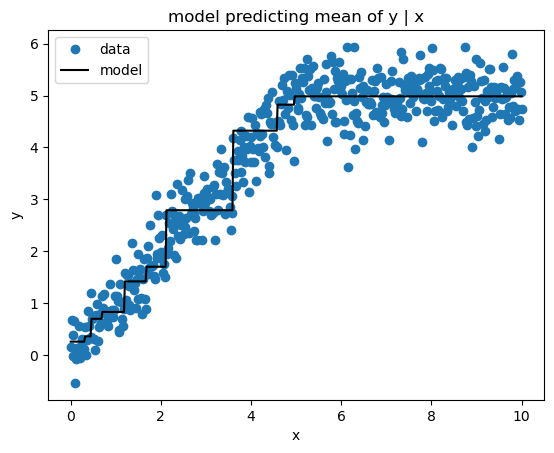

In [7]:
#| echo: false
#| fig-alt: Scatterplot showing data and model prediction of y given x

import matplotlib.pyplot as plt

# fig, ax = plt.subplot()
plt.plot(x.ravel(), y, 'o', label='data')
plt.plot(x.ravel(), pred, '-k', label='model')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('model predicting mean of y | x');

### Mean Absolute Error
Mean Absolute Error (a.k.a.Least Absolute Deviations) loss produces estimates of the median target value conditioned on the feature values. Here's the implementation.

In [8]:
x, y = make_test_data(500, 0.4)

In [9]:

# from scratch GBM
class AbsoluteErrorLoss():
    '''User-Defined Absolute Error Loss'''
    
    def loss(self, y, preds):
        return np.mean(np.abs(y - preds))
    
    def negative_gradient(self, y, preds):
        return np.sign(y - preds)


gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5,
                              max_depth=1)
gbm.fit(x, y, AbsoluteErrorLoss())
pred = gbm.predict(x)

In [10]:
#| output: false
# scikit-learn GBM
sk_gbm = GradientBoostingRegressor(n_estimators=10,
                                   learning_rate=0.5,
                                   max_depth=1,
                                   loss='absolute_error')
sk_gbm.fit(x, y)
sk_pred = sk_gbm.predict(x)

In [11]:
print_model_loss_scores(AbsoluteErrorLoss(), y, pred, sk_pred)

From Scratch Loss = 0.3225
Scikit-Learn Loss = 0.3208


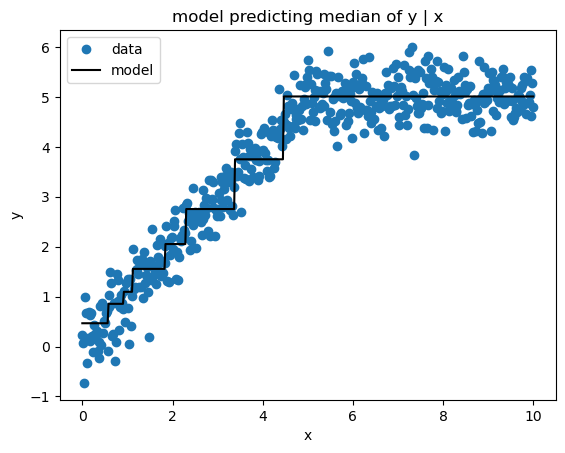

In [12]:
#| echo: false
#| fig-alt: Figure showing scatterplot of data and model prediction of median of y given x
# fig, ax = plt.subplot()
plt.plot(x.ravel(), y, 'o', label='data')
plt.plot(x.ravel(), pred, '-k', label='model')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('model predicting median of y | x');

### Quantile Loss
Quantile loss yields estimates of a given quantile of the target variable conditioned on the features. Here's my implementation.

In [13]:
x, y = make_test_data(500, 1)

In [14]:

# from scratch GBM
class QuantileLoss():
    '''Quantile Loss
    
    Parameters
    ----------
    alpha : float
        quantile to be estimated, 0 < alpha < 1
    '''
    
    def __init__(self, alpha):
        if alpha < 0 or alpha >1:
            raise ValueError('alpha must be between 0 and 1')
        self.alpha = alpha
        
    def loss(self, y, preds):
        e = y - preds
        return np.mean(np.where(e > 0, self.alpha * e, (self.alpha - 1) * e))
    
    def negative_gradient(self, y, preds):
        e = y - preds 
        return np.where(e > 0, self.alpha, self.alpha - 1)

gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5,
                             max_depth=1)
gbm.fit(x, y, QuantileLoss(alpha=0.9))
pred = gbm.predict(x)    

In [15]:
# scikit-learn GBM
sk_gbm = GradientBoostingRegressor(n_estimators=10,
                                 learning_rate=0.5,
                                 max_depth=1,
                                 loss='quantile', alpha=0.9)
sk_gbm.fit(x, y)
sk_pred = sk_gbm.predict(x)

In [16]:
print_model_loss_scores(QuantileLoss(alpha=0.9), y, pred, sk_pred)

From Scratch Loss = 0.1853
Scikit-Learn Loss = 0.1856


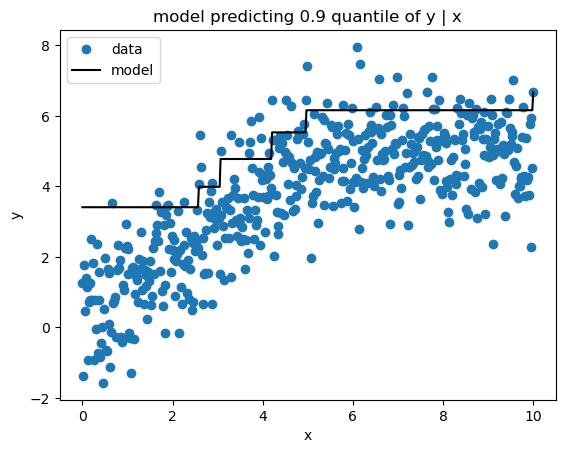

In [17]:
#| echo: false
#| fig-alt: Figure showing scatterplot of data and model prediction of 0.9 quantile of y given x
plt.plot(x, y, 'o', label='data')
plt.plot(x, pred, 'k-', label='model')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('model predicting 0.9 quantile of y | x');

### Binary Cross Entropy Loss
The previous losses are useful for regression problems, where the target is numeric. But we can also solve classification problems, simply by swapping in an appropriate loss function. Here we'll implement binary cross entropy, a.k.a. binary deviance, a.k.a. negative binomial log likelihood (sometimes abusively called log loss). One thing to remember is that, as with logistic regression, our model is actually  predicting the log odds ratio, not the probability of the positive class. Thus we use expit transformations (the inverse of logit) whenever probabilities are needed, e.g., when predicting the probability that an observation belongs to the positive class. 

In [18]:
# make categorical test data

def expit(t):
    return np.exp(t) / (1 + np.exp(t))

x = np.linspace(-3, 3, 500)
p = expit(x)
y = rng.binomial(1, p, size=p.shape)
x = x.reshape(-1,1)

In [19]:
# from scratch GBM
class BinaryCrossEntropyLoss():
    '''Binary Cross Entropy Loss
    
    Note that the predictions should be log odds ratios.
    '''
    
    def __init__(self):
        self.expit = lambda t: np.exp(t) / (1 + np.exp(t))
    
    def loss(self, y, preds):
        p = self.expit(preds)
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    
    def negative_gradient(self, y, preds):
        p = self.expit(preds)
        return y / p - (1 - y) / (1 - p)

    
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5,
                              max_depth=1)
gbm.fit(x, y, BinaryCrossEntropyLoss())
pred = expit(gbm.predict(x))

In [20]:
# scikit-learn GBM
sk_gbm = GradientBoostingClassifier(n_estimators=10,
                                    learning_rate=0.5,
                                    max_depth=1,
                                    loss='log_loss')
sk_gbm.fit(x, y)
sk_pred = sk_gbm.predict_proba(x)[:, 1]

In [21]:
print_model_loss_scores(BinaryCrossEntropyLoss(), y, pred, sk_pred)

From Scratch Loss = 0.6379
Scikit-Learn Loss = 0.6403


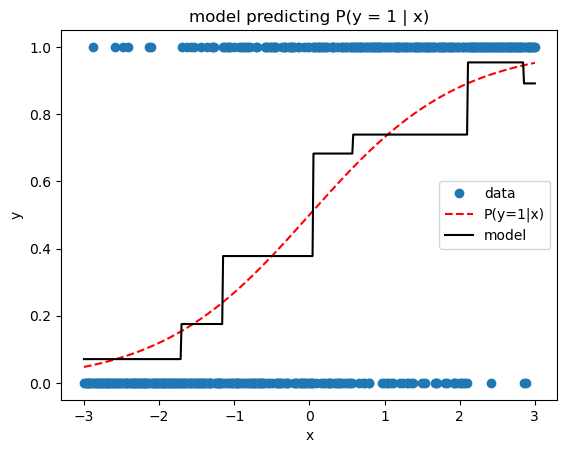

In [22]:
#| echo: false
#| fig-alt: Figure showing data and model prediction of probability that y equals one given x
plt.plot(x, y, 'o', label='data')
plt.plot(x, p, '--r', label='P(y=1|x)')
plt.plot(x, pred, '-k', label='model')
plt.title('model predicting P(y = 1 | x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

## Wrapping Up
Woohoo! We did it! We finally made it through Friedman's paper in its entirety, and we implemented the generic gradient boosting algorithm which works with any differentiable loss function.
If you made it this far, great job, gold star!
By now you hopefully have a pretty solid grasp on  gradient boosting, which is good, because soon we're going to dive into the modern Newton descent gradient boosting frameworks like XGBoost.
Onward!


## References
Friedman's 2001 paper: [Greedy Function Approximation: A Gradient Boosting Machine](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf)